In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy import random
import matplotlib as mpl
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

plt.style.use(['seaborn-bright', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})

In [5]:
data = pd.read_csv('data.csv',low_memory=True )
X = data.drop(columns = ['charged_off', 'issue_d', 'purpose'], axis=1)
y = data['charged_off']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)
simple = SimpleImputer(strategy='mean')
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
X_train[numerical_cols] = simple.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = simple.fit_transform(X_test[numerical_cols])

# Upsampling and oversampling the data 
over = SMOTENC(categorical_features=[X_train.dtypes==object],sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.7)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
	
# transform the dataset
X_traines, y_traines = over.fit_resample(X_train, y_train)

# Preparing data in tensorflow fashion
dftrain = X_traines.merge(y_traines, left_index=True, right_index=True)
dfeval = X_test.merge(y_test, left_index=True, right_index=True)
y_train = dftrain.pop('charged_off')
y_eval = dfeval.pop('charged_off')
# Modify the column to integer
dftrain['term'] = dftrain.term.astype(int)
dfeval['term'] = dfeval.term.astype(int)
# Dropping correlated features 
dftrain = dftrain.drop(['installment', 'open_acc', 'pub_rec_bankruptcies'], axis=1)
dfeval = dfeval.drop(['installment', 'open_acc', 'pub_rec_bankruptcies'], axis=1)

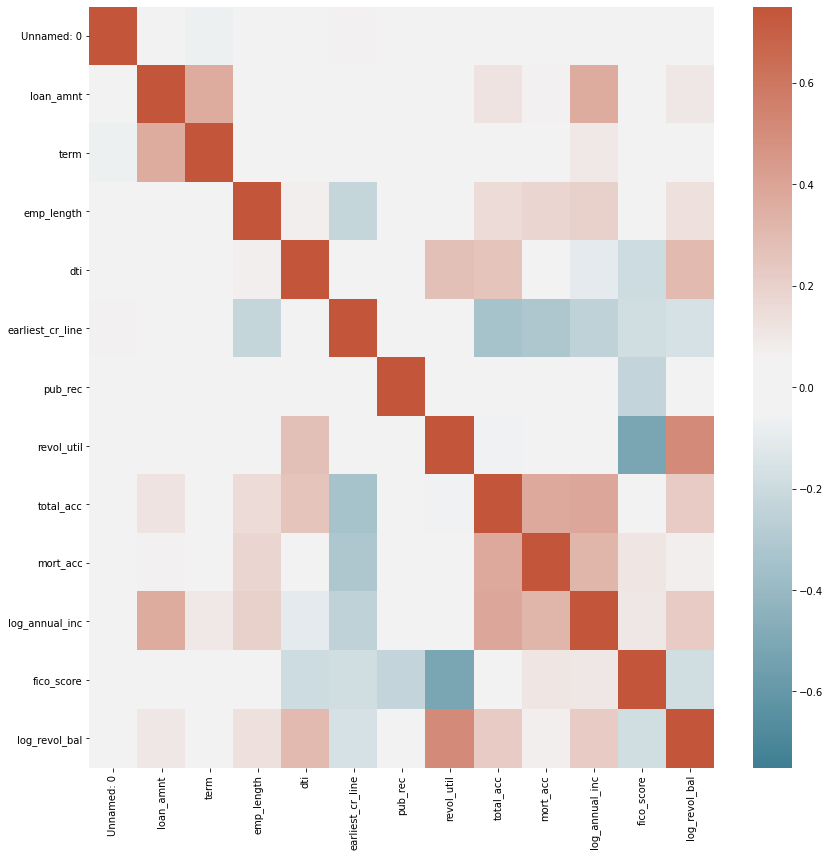

In [331]:
# Write a heatmap

def heatmap(data,figsize=(8,8), annot=False):
    #plot heatmap to find multicollinearity
    plt.figure(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap,annot=annot);


heatmap(dftrain,figsize=(14,14))
clear_output()

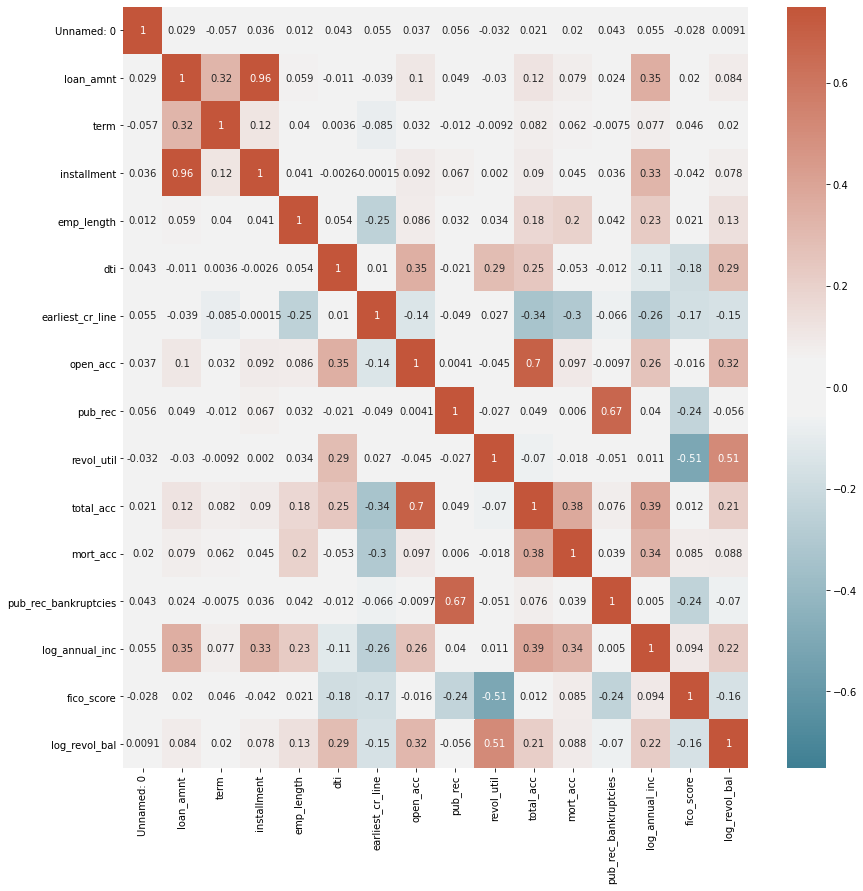

In [196]:
heatmap(dftrain,figsize=(14,14), annot=True);

In [6]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['home_ownership', 'term', 'verification_status', 'application_type']  
NUMERIC_COLUMNS = [ 'loan_amnt', 'emp_length', 'dti',
       'earliest_cr_line', 'revol_util', 'total_acc',
       'mort_acc', 'log_annual_inc', 'fico_score',
       'log_revol_bal']


In [7]:
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                                vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  print(dftrain[feature_name])
  vocabulary = dftrain[feature_name].unique()
  
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))
                                                        
clear_output()

In [8]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [296]:
# Let’s first train a logistic regression model to get a benchmark:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
logit_result = linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s3/wd0mk37n1jl88qx9p9sxlxm80000gn/T/tmp9s07q9jx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INF

In [11]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  'learning_rate':0.1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.850784
accuracy_baseline,0.852184
auc,0.684397
auc_precision_recall,0.262744
average_loss,0.400304
label/mean,0.147816
loss,0.400304
precision,0.454545
prediction/mean,0.196060
recall,0.047348


In [12]:
# Make predictions. Here are the directional feature contributions 
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s3/wd0mk37n1jl88qx9p9sxlxm80000gn/T/tmpbugnvasp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
IN

,count,mean,std,min,25%,50%,75%,max
revol_util,3572.0,0.000947,0.016556,-0.062198,-0.011308,0.005728,0.011791,0.050177
fico_score,3572.0,-0.000111,0.025338,-0.072899,-0.024249,0.003041,0.022631,0.054965
emp_length,3572.0,0.004773,0.019435,-0.041090,-0.009435,-0.001257,0.018488,0.059432
home_ownership,3572.0,0.000679,0.021394,-0.032640,-0.016808,-0.006502,0.021309,0.032293
earliest_cr_line,3572.0,-0.001486,0.007179,-0.047201,-0.003707,-0.001522,0.000295,0.082252
term,3572.0,-0.003305,0.033380,-0.049879,-0.023617,-0.008413,-0.001465,0.157600
loan_amnt,3572.0,-0.011871,0.027925,-0.069875,-0.028758,-0.017074,-0.003541,0.196605
verification_status,3572.0,-0.000153,0.005321,-0.009845,-0.005431,0.002789,0.004653,0.006545
dti,3572.0,0.003167,0.017548,-0.055728,-0.003198,0.003260,0.011857,0.100232
total_acc,3572.0,-0.003679,0.007312,-0.062086,-0.007183,-0.002564,0.000213,0.073663


In [67]:
# Plot for the individual loaner. 
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=sns.color_palette()[:6],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

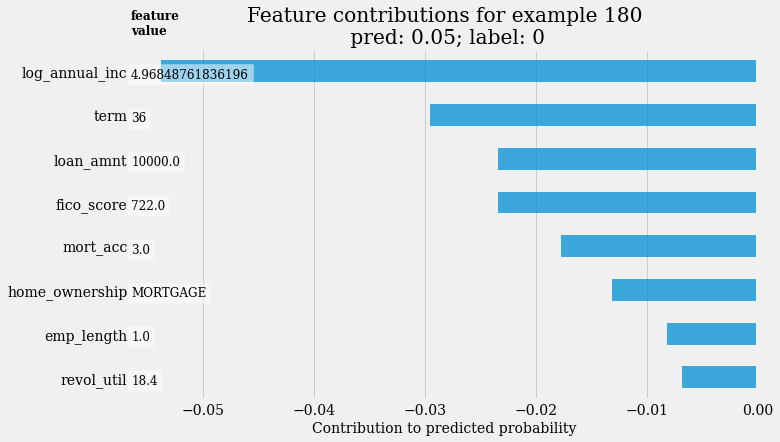

In [38]:
# Plot results.
sns_colors = sns.color_palette('colorblind')
ID = 180
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

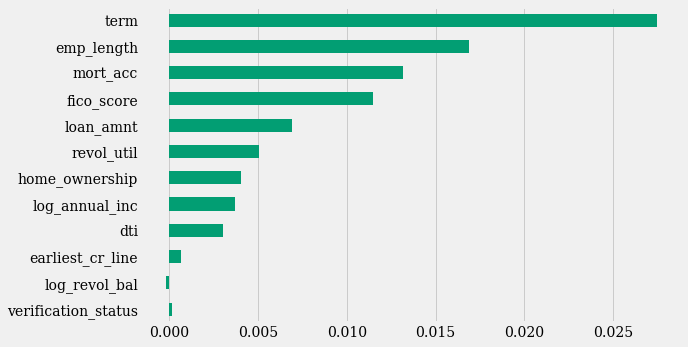

In [34]:
# Permutation feature importance 
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        random.seed(12)
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dftrain, y_train, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)
clear_output()
sorted_ix = df_imp.abs().sort_values().index
with sns.diverging_palette(160, 275, s=100, l=55, n=4):
    ax = df_imp[sorted_ix][-12:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
    ax.grid(False, axis='y')
    plt.gcf().subplots_adjust(left=0.20, bottom=0.15)
    # ax.set_title('Permutation feature importance', )
    plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/permutation_feature_importance.png')

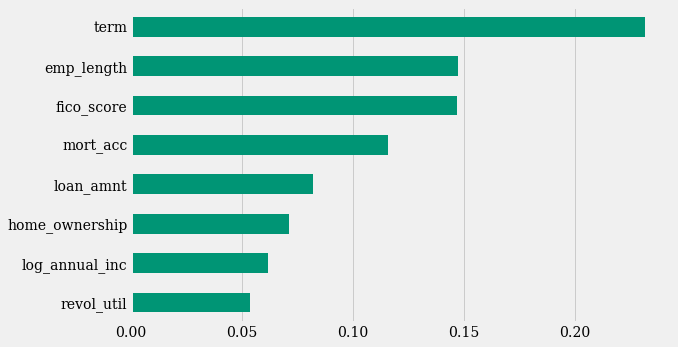

In [32]:
# Gain-based feature importance
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
with sns.diverging_palette(160, 275, s=100, l=55, n=2):
    N = 8
    ax = (df_imp.iloc[0:N][::-1]
        .plot(kind='barh',
            # color=sns_colors[0],
            # title='Gain feature importances',
            figsize=(10, 6)))
    ax.grid(False, axis='y')
    plt.gcf().subplots_adjust(left=0.20, bottom=0.15)
    # ax.set_title('Permutation feature importance', )
    plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/gain-based_importance.png')

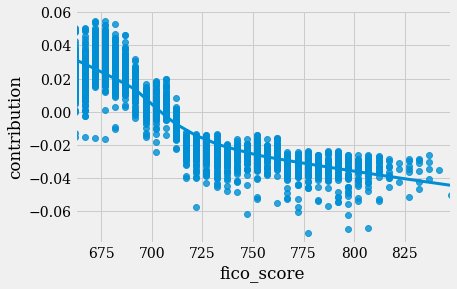

In [92]:
# individual direct feature contributions
FEATURE = 'fico_score'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
# ax.set_xlim(0, 100)
plt.show()

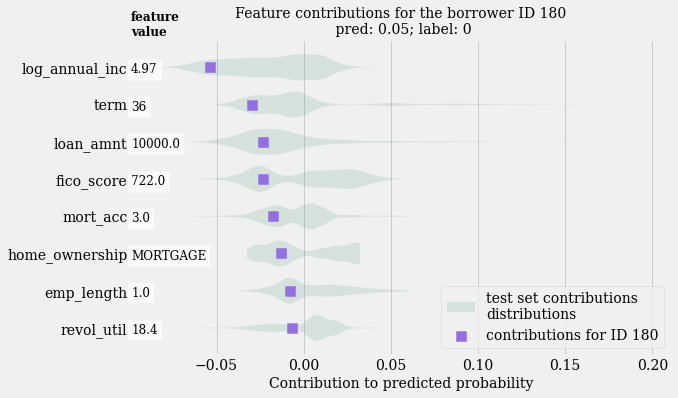

In [96]:
# sns_colors = sns.color_palette('colorblind')
def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    feature_values[7] = '{:1.2f}'.format(feature_values[7]) #edit the first number to two decimal points
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.8))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)
sns_colors = sns.diverging_palette(150, 275, s=80, l=55, n=9)
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-8:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)


  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              # color=sns.color_palette()[2],
              color=sns_colors[8],
              s=100,
              marker="s",
              label='contributions for ID 180')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='test set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right',fancybox=True, frameon=True)
  # legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)
# Plot this example.


dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for the borrower ID {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]), {'fontsize':'medium'})
plt.gcf().subplots_adjust(left=0.20, bottom=0.15)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/artworks/feature_contributions.png')